In [4]:
!pip install lime

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# optionally for imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# explanatory tools
import shap
from lime.lime_tabular import LimeTabularExplainer


In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [6]:
GENERATE_SYNTHETIC = True  # If True, create demo data instead of loading CSV
DATA_PATH = "patient_data.csv"  # used if GENERATE_SYNTHETIC is False
TARGET_COL = "mortality_90d"
DIABETES_FLAG_COL = "diabetes"
MODEL_OUTPUT_PATH = "rf_90day_mortality.joblib"
SHAP_HTML = "shap_force_patient.html"
LIME_HTML = "lime_patient.html"


In [7]:
def generate_synthetic_data(n=5000, diabetes_rate=0.3, event_rate=0.05):
    """Create synthetic patient dataset for demonstration."""
    rng = np.random.RandomState(RANDOM_STATE)
    df = pd.DataFrame({
        "age": rng.normal(70, 12, size=n).clip(18, 100).round().astype(int),
        "bmi": rng.normal(28, 6, size=n).round(1),
        "systolic_bp": rng.normal(135, 18, size=n).round().astype(int),
        "hdl": rng.normal(50, 15, size=n).round(1),
        "ldl": rng.normal(110, 30, size=n).round(1),
        "creatinine": np.abs(rng.normal(1.1, 0.6, size=n)).round(2),
        "gender": rng.choice(["male", "female"], size=n),
        "race": rng.choice(["white", "black", "asian", "other"], size=n, p=[0.6,0.2,0.1,0.1]),
    })
    # Diabetes flag
    df[DIABETES_FLAG_COL] = rng.rand(n) < diabetes_rate

    # Mortality probability (artificial)
    base_prob = 0.01 + 0.001*(df["age"] - 50) + 0.01*(df[DIABETES_FLAG_COL].astype(int))
    base_prob += 0.02 * ((df["creatinine"] > 1.5).astype(int))
    base_prob += 0.01 * ((df["systolic_bp"] > 180).astype(int))
    base_prob = np.clip(base_prob, 0.001, 0.5)

    df[TARGET_COL] = (rng.rand(n) < base_prob).astype(int)
    return df


In [8]:
def load_and_filter_data(path=DATA_PATH, generate_synth=GENERATE_SYNTHETIC):
    if generate_synth:
        df = generate_synthetic_data()
    else:
        if not os.path.exists(path):
            raise FileNotFoundError(f"{path} not found. Set GENERATE_SYNTHETIC=True or provide CSV.")
        df = pd.read_csv(path)

    # Ensure required columns exist
    for c in [DIABETES_FLAG_COL, TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"Required column '{c}' not found in dataset")

    # Filter to diabetic patients only
    df_diab = df[df[DIABETES_FLAG_COL].astype(bool)].copy()
    if df_diab.shape[0] == 0:
        raise ValueError("No diabetic patients found after filtering.")

    # Separate features/target
    y = df_diab[TARGET_COL].astype(int)
    X = df_diab.drop(columns=[TARGET_COL])

    return X, y, df_diab


In [14]:
def build_preprocessor(X):
    # Identify numeric and categorical columns heuristically
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    # Remove boolean flags from numeric if present
    numeric_cols = [c for c in numeric_cols if c not in [DIABETES_FLAG_COL]]
    categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    # remove target-like columns
    if DIABETES_FLAG_COL in categorical_cols:
        categorical_cols.remove(DIABETES_FLAG_COL)

    # If any columns are in both lists, resolve (rare)
    categorical_cols = [c for c in categorical_cols if c not in numeric_cols]

    num_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, categorical_cols)
    ], remainder="drop")

    return preprocessor, numeric_cols, categorical_cols


In [10]:
def train_evaluate(X, y, use_smote=True):
    preprocessor, numeric_cols, categorical_cols = build_preprocessor(X)

    # Model
    rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")

    if use_smote:
        # SMOTE only on training data inside pipeline via imblearn
        # Note: SMOTE requires numeric features. We apply SMOTE after encoding.
        pipeline = ImbPipeline(steps=[
            ("preproc", preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf", rf)
        ])
    else:
        pipeline = Pipeline(steps=[
            ("preproc", preprocessor),
            ("clf", rf)
        ])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Optionally calibrate probabilities (improves probability estimates)
    calib = CalibratedClassifierCV(pipeline, cv=3, method="sigmoid")  # or 'isotonic' if more data
    calib.fit(X_train, y_train)

    # Save final model and preprocessors for later use
    joblib.dump({
        "pipeline": pipeline,
        "calibrated": calib,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols
    }, MODEL_OUTPUT_PATH)

    # Predictions and evaluation
    y_pred_proba = calib.predict_proba(X_test)[:, 1]
    y_pred = calib.predict(X_test)

    # Metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    brier = brier_score_loss(y_test, y_pred_proba)

    print("=== Evaluation on test set ===")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC (Average Precision): {pr_auc:.4f}")
    print(f"Brier score: {brier:.4f}")
    print("\nClassification report (threshold=0.5):")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix (threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--", linewidth=0.8)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.legend()
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend()
    plt.show()

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1)
    plt.plot([0,1],[0,1],"--", linewidth=0.8)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration plot")
    plt.show()

    # Return saved objects and test split for explanations
    saved = joblib.load(MODEL_OUTPUT_PATH)
    return saved, (X_test, y_test)

In [11]:
def shap_explain(saved_obj, X_reference, instance_idx=0, save_html=True):
    """
    saved_obj: dict saved from training containing 'pipeline' and/or 'calibrated'
    X_reference: DataFrame of raw X_test (unprocessed)
    instance_idx: index within X_reference to explain
    """
    calibrated = saved_obj["calibrated"]
    pipeline = saved_obj["pipeline"]  # pipeline includes preprocessing
    preproc = pipeline.named_steps.get("preproc", None)
    clf = pipeline.named_steps.get("clf", None)

    if clf is None:
        # If pipeline is a simple pipeline without 'clf' named step, try to find last estimator
        clf = pipeline.steps[-1][1]

    # We need the processed feature matrix for SHAP TreeExplainer (it expects the model input)
    X_processed = preproc.transform(X_reference)

    # For RandomForest, use TreeExplainer on the underlying random forest (not the calibrated wrapper).
    # If a calibrated model is used, shap values on raw RF are still meaningful for feature contribution
    rf_model = clf  # RandomForestClassifier
    explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_processed)  # for RF returns list [class0, class1]

    # Get feature names after transformation (OneHot columns)
    try:
        # Compose feature names: numeric then one-hot encoder categories
        num_cols = saved_obj["numeric_cols"]
        cat_cols = saved_obj["categorical_cols"]
        # Retrieve categories from fitted OneHotEncoder
        ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
        ohe_feature_names = []
        for i, cat in enumerate(cat_cols):
            cats = ohe.categories_[i]
            ohe_feature_names.extend([f"{cat}__{c}" for c in cats])
        feature_names = num_cols + ohe_feature_names
    except Exception:
        # fallback
        feature_names = [f"f{i}" for i in range(X_processed.shape[1])]

    # Global summary plot (class 1 SHAP values)
    shap.summary_plot(shap_values[1], X_processed, feature_names=feature_names, show=True)

    # Local explanation: force plot for a single instance (class 1)
    instance = X_processed[instance_idx:instance_idx+1]
    sv_instance = shap_values[1][instance_idx]

    # Create HTML force plot (works well in notebook; we save as standalone HTML)
    shap_html = shap.force_plot(explainer.expected_value[1], sv_instance, instance,
                                feature_names=feature_names, matplotlib=False, show=False)

    if save_html:
        # Save HTML
        shap.save_html(SHAP_HTML, shap_html)
        print(f"Saved SHAP force plot HTML to {SHAP_HTML}")

    # Return objects for further programmatic use
    return {
        "explainer": explainer,
        "shap_values": shap_values,
        "feature_names": feature_names
    }

In [12]:
def lime_explain(saved_obj, X_train_sample, X_test, instance_idx=0, save_html=True):
    """
    Build a LimeTabularExplainer on the training data (after preprocessing).
    Lime expects the raw data array (unencoded) and a function that returns probabilities.

    saved_obj: loaded joblib object containing pipeline and calibrated model
    X_train_sample: DataFrame used for training (or a sample of it)
    X_test: DataFrame to explain instances from
    instance_idx: index within X_test to explain
    """
    calibrated = saved_obj["calibrated"]
    pipeline = saved_obj["pipeline"]
    preproc = pipeline.named_steps.get("preproc", None)
    clf = pipeline.named_steps.get("clf", None)
    numeric_cols = saved_obj["numeric_cols"]
    categorical_cols = saved_obj["categorical_cols"]

    # We need a predict_proba function that accepts raw dataframe-like rows and returns probas
    def predict_proba_raw(X_raw_numpy):
        """
        LIME will pass numpy array representing the original features (untransformed).
        We must re-create a DataFrame with the original columns order used by training.
        We'll accept X_raw_numpy shaped (n_samples, n_features_raw).
        """
        if isinstance(X_raw_numpy, np.ndarray):
            # Reconstruct a dataframe with the training columns
            cols = list(numeric_cols) + list(categorical_cols)
            # But the raw X may not be in this order. To be safe, we'll use the original training dataframe's column order:
            # We'll assume the user passed X_train_sample with the same columns as X used to train.
            df_raw = pd.DataFrame(X_raw_numpy, columns=X_train_sample.columns)
        else:
            df_raw = pd.DataFrame(X_raw_numpy)

        # Use calibrated pipeline to predict probabilities
        # For pipelines expecting pandas DataFrame, calibrated.predict_proba should work.
        probas = calibrated.predict_proba(df_raw)
        return probas

    # Create LIME explainer using training data (numpy) and feature names
    X_train_np = X_train_sample.values
    feature_names = X_train_sample.columns.tolist()
    class_names = ["alive_90d", "dead_90d"]

    lime_exp = LimeTabularExplainer(
        training_data=X_train_np,
        feature_names=feature_names,
        class_names=class_names,
        discretize_continuous=True,
        mode="classification",
        random_state=RANDOM_STATE
    )

    instance = X_test.iloc[instance_idx]
    exp = lime_exp.explain_instance(
        data_row=instance.values,
        predict_fn=predict_proba_raw,
        num_features=10
    )

    print("LIME explanation (as list):")
    print(exp.as_list())

    if save_html:
        with open(LIME_HTML, "w") as f:
            f.write(exp.as_html())
        print(f"Saved LIME explanation HTML to {LIME_HTML}")

    return exp

=== Evaluation on test set ===
ROC AUC: 0.5065
PR AUC (Average Precision): 0.0473
Brier score: 0.0394

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9590    1.0000    0.9791       374
           1     0.0000    0.0000    0.0000        16

    accuracy                         0.9590       390
   macro avg     0.4795    0.5000    0.4895       390
weighted avg     0.9196    0.9590    0.9389       390



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


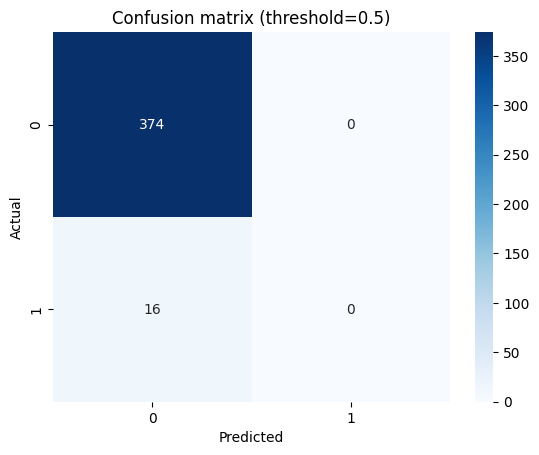

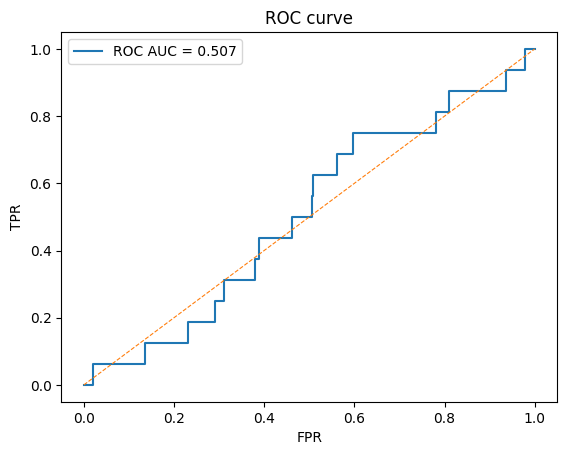

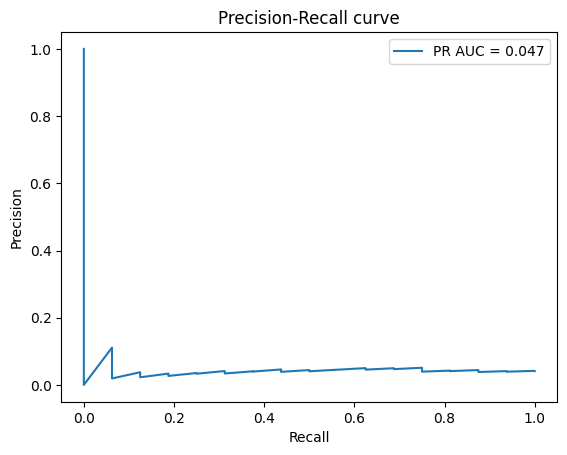

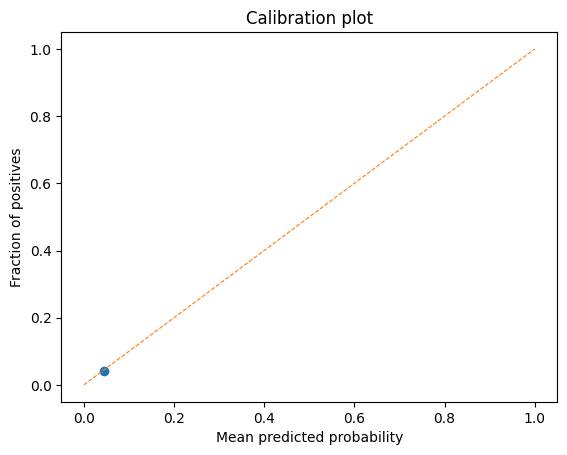

/tmp/ipython-input-1722173976.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], X_processed, feature_names=feature_names, show=True)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [15]:
X, y, df_diab = load_and_filter_data()

# Train and evaluate
saved_obj, (X_test, y_test) = train_evaluate(X, y, use_smote=True)

# For LIME we need a sample of training data in raw (unpreprocessed) form.
# We'll take a sample from original filtered dataframe minus test set rows:
# Simple approach: sample from df_diab rows that are in X_test index complement
# Here we'll just sample from the original X (this is acceptable if not overlapping heavily)
X_train_sample = X.sample(n=min(500, X.shape[0]), random_state=RANDOM_STATE)

# SHAP explain (example instance)
shap_objects = shap_explain(saved_obj, X_test, instance_idx=0, save_html=True)

# LIME explain (same instance)
lime_exp = lime_explain(saved_obj, X_train_sample, X_test, instance_idx=0, save_html=True)

print("Done. Model and explanation HTML files saved.")